In [1]:
import numpy as np
from glob import glob
import xroms

import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import scipy.signal as sig
import sys
import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
# import seawater as sw
from dask.diagnostics import ProgressBar
import dask
from dask.distributed import Client, LocalCluster

warnings.filterwarnings("ignore")

In [2]:
#plot specs

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']


In [3]:
# client = Client(processes=False)
client = Client(n_workers=15,processes=True)
client

<Client: 'tcp://127.0.0.1:42083' processes=15 threads=135, memory=502.98 GiB>

2024-09-01 09:59:48,706 - distributed.nanny - WARNING - Restarting worker
2024-09-01 09:59:48,934 - distributed.worker_memory - WARNING - Worker tcp://127.0.0.1:32877 (pid=3023796) exceeded 95% memory budget. Restarting...
2024-09-01 09:59:48,946 - distributed.nanny - WARNING - Restarting worker
2024-09-01 09:59:48,949 - distributed.nanny - WARNING - Restarting worker
2024-09-01 09:59:49,162 - distributed.nanny - WARNING - Restarting worker
2024-09-01 09:59:49,380 - distributed.nanny - WARNING - Restarting worker
2024-09-01 09:59:49,602 - distributed.nanny - WARNING - Restarting worker
2024-09-01 09:59:49,620 - distributed.nanny - WARNING - Restarting worker
2024-09-01 09:59:50,058 - distributed.nanny - WARNING - Restarting worker
2024-09-01 09:59:50,298 - distributed.nanny - WARNING - Restarting worker
2024-09-01 09:59:50,313 - distributed.nanny - WARNING - Restarting worker
2024-09-01 09:59:50,772 - distributed.nanny - WARNING - Restarting worker
2024-09-01 09:59:50,824 - distributed

In [4]:
# chunks={'time_counter':10, 'x_rho':50, 'y_rho':190,'s_rho':80,'s_w':80}

# chunks={'time_counter':1,'x_rho':1000,"x_u":1000,"x_v":1000,
#                         'y_rho':1520,"y_u":1520,"y_v":1520,'s_rho':80,'s_w':80}

chunks={'time_counter':1,'x_rho':100,"x_u":100,"x_v":100,
                        'y_rho':152,"y_u":152,"y_v":152,'s_rho':80,'s_w':80}


# chunks={'time_counter':1,'x_rho':1000,"x_u":1000,"x_v":1000,
#                         'y_rho':1520,"y_u":1520,"y_v":1520,'s_rho':80,'s_w':80}

# M='01'
path='/data/pacific/lrenault/SASI/CROCO/'


# varf=xr.open_mfdataset(path + 'FULL/SASI*2012-{0}*.nc'.format(M),data_vars='minimal')
# vart=xr.open_mfdataset(path + 'SMTH/SASI*2012-{0}*.nc'.format(M),data_vars='minimal')

varf=xr.open_mfdataset(path + 'FULL/SASI*2012*.nc',data_vars='minimal',chunks=chunks)
vart=xr.open_mfdataset(path + 'SMTH/SASI*2012*.nc',data_vars='minimal',chunks=chunks)

In [5]:
varx = varf.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v","x_w":"xi_w",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
df,gf=xroms.roms_dataset(varx,Vtransform=varx.Vtransform.data)

vary = vart.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
dt,gt=xroms.roms_dataset(vary,Vtransform=vary.Vtransform.data)

2024-09-01 09:51:47,178 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


## Calculating global APE (Done)

In [6]:
rho_full=df.rho[:,:,120:-120,120:800]+df.rho0
rho_smth=dt.rho[:,:,120:-120,120:800]+dt.rho0

g=9.8

In [7]:
b_full=-g*(rho_full - df.rho0)/df.rho0
b_smth=-g*(rho_smth - dt.rho0)/dt.rho0

In [8]:
zSurf=rho_full.z_rho0.compute().max()
zBott=rho_full.z_rho0.compute().min()

In [9]:
z_surf_interp=-2
dz=10
z_interp=np.linspace(z_surf_interp,zBott, np.int(np.abs(zBott/dz)))
print('dz={0:.1f}'.format(np.diff(z_interp).mean()) +  '   n_z={0:.0f}'.format(np.int(np.abs(zBott/dz))))

dz=-10.0   n_z=507


### Setting $dx,dy,dz,dA,dV$

In [10]:
d_field=rho_full[0,:,:,:].xroms.isoslice(z_interp).compute()

DeltaX=(d_field*0+500).compute()
DeltaY=(d_field*0+500).compute()
DeltaZ=xr.apply_ufunc(np.gradient,d_field['z_rho'],kwargs={'axis':0})
DeltaA=DeltaX*DeltaY
DeltaV=np.abs(DeltaA*DeltaZ)

### $z*$ 

In [30]:
rho_path='/data/pacific/iufarias/tseng_z_star/rho_star/'
rho_files_full=glob(rho_path+'rho_star_full_*.nc');rho_files_full.sort()
rho_files_smth=glob(rho_path+'rho_star_smth_*.nc');rho_files_smth.sort()


In [21]:
path='/data/pacific/iufarias/tseng_z_star/'
files_full=glob(path+'z_star_full*.nc');files_full.sort()
files_smth=glob(path+'z_star_smth*.nc');files_smth.sort()


In [52]:
# %%time
# # i_x=0

# APE_full=[]
# APE_smth=[]

# # for i_x in range():
# for i_x in range(b_full.shape[0]):
#     z_star_interp_full=xr.open_dataarray(files_full[i_x])[:,:,1:-1,1:-1]
#     b_interp_full=b_full[i_x,:,:,:].xroms.isoslice(z_interp).expand_dims('ocean_time').compute()

#     PE_full=((z_interp[None,:,None,None])*b_interp_full*DeltaV).sum()
#     BPE_full=((z_star_interp_full)*b_interp_full*DeltaV).sum()
#     APE_full.append(PE_full-BPE_full)

    
#     z_star_interp_smth=xr.open_dataarray(files_smth[i_x])[:,:,1:-1,1:-1]
#     b_interp_smth=b_smth[i_x,:,:,:].xroms.isoslice(z_interp).expand_dims('ocean_time').compute()

#     PE_smth=((z_interp[None,:,None,None])*b_interp_smth*DeltaV).sum()
#     BPE_smth=((z_star_interp_smth)*b_interp_smth*DeltaV).sum()
#     APE_smth.append(PE_smth-BPE_smth)
    
# APE_full_xr=xr.concat(APE_full,dim=b_full.ocean_time)
# APE_smth_xr=xr.concat(APE_smth,dim=b_full.ocean_time)

# del APE_full_xr.attrs['grid']
# del APE_smth_xr.attrs['grid']


# APE_full_xr.to_netcdf('/data/pacific/iufarias/APE_global/APE_full_global.nc','w')
# APE_smth_xr.to_netcdf('/data/pacific/iufarias/APE_global/APE_smth_global.nc','w')


CPU times: user 5h 13min 15s, sys: 5h 12min 54s, total: 10h 26min 9s
Wall time: 1d 1h 1min 23s


## Loading APE global

In [106]:
APE_full_xr=xr.open_dataarray('/data/pacific/iufarias/APE_global/APE_full_global.nc')
APE_smth_xr=xr.open_dataarray('/data/pacific/iufarias/APE_global/APE_smth_global.nc')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


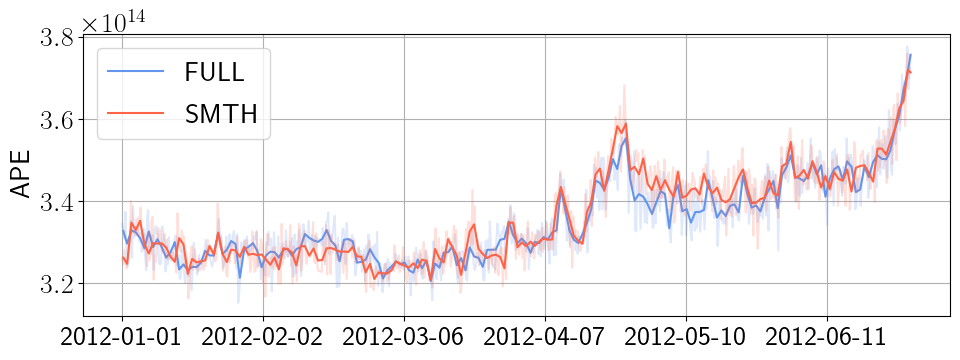

In [80]:
plt.figure(figsize=(10,4))

plt.plot(APE_full_xr.ocean_time,APE_full_xr,color='cornflowerblue',alpha=0.2)
plt.plot(APE_full_xr.ocean_time.groupby('ocean_time.dayofyear').mean(),
         APE_full_xr.groupby('ocean_time.dayofyear').mean(),color='cornflowerblue',label='FULL')

plt.plot(APE_smth_xr.ocean_time,APE_smth_xr,color='tomato',alpha=0.2)
plt.plot(APE_smth_xr.ocean_time.groupby('ocean_time.dayofyear').mean(),
         APE_smth_xr.groupby('ocean_time.dayofyear').mean(),color='tomato',label='SMTH')
plt.legend()

plt.ylabel('APE []')
plt.xticks(APE_full_xr.ocean_time[::130])
plt.grid()
plt.tight_layout()

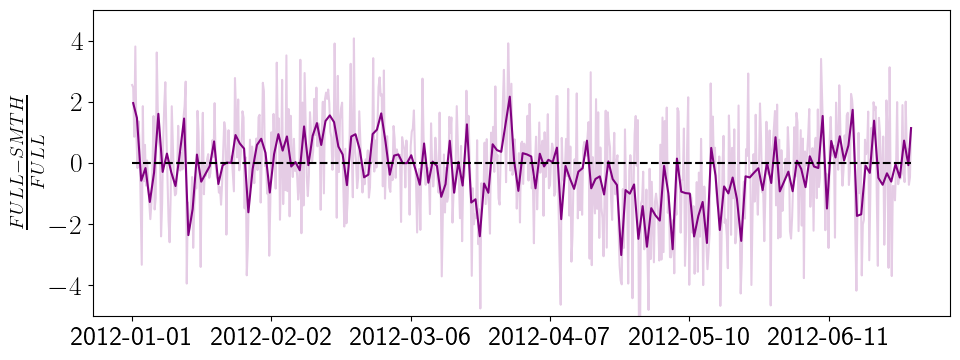

In [88]:
plt.figure(figsize=(10,4))

plt.plot(APE_full_xr.ocean_time,100*(APE_full_xr-APE_smth_xr)/APE_full_xr,color='purple',alpha=0.2)
plt.plot(APE_full_xr.ocean_time.groupby('ocean_time.dayofyear').mean(),
         100*((APE_full_xr-APE_smth_xr)/APE_full_xr).groupby('ocean_time.dayofyear').mean(),
         color='purple')

plt.plot(APE_full_xr.ocean_time,APE_full_xr*0,'k--')
plt.ylabel(r'$\frac{FULL-SMTH}{FULL}$')
plt.xticks(APE_full_xr.ocean_time[::130])
plt.ylim(-5,5)
plt.tight_layout()

In [90]:
i_x=0
z_star_interp_full=xr.open_dataarray(files_full[i_x])[:,:,1:-1,1:-1]
b_interp_full=b_full[i_x,:,:,:].xroms.isoslice(z_interp).expand_dims('ocean_time').compute()


z_star_interp_smth=xr.open_dataarray(files_smth[i_x])[:,:,1:-1,1:-1]
b_interp_smth=b_smth[i_x,:,:,:].xroms.isoslice(z_interp).expand_dims('ocean_time').compute()


In [ ]:
APE_full_xr.mean()/APE_smth_xr.mean()

<xarray.DataArray ()>
array(0.99774746)
Coordinates:
    time_instant  datetime64[ns] 2012-01-01T06:00:00
Attributes:
    long_name:           density anomaly
    units:               kilogram meter-3
    online_operation:    instant
    interval_operation:  6 h
    interval_write:      6 h
    cell_methods:        time: point